In [434]:
! pip install xgboost
!pip install py7zr
!pip install lightgbm

In [435]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import tqdm
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [436]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kagglesdsdata/competitions/4117/46665/train.7z?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1623603938&Signature=skQ6FEfg0rcl1z8GB9PmF5nyF2ncVpayj1WqYChbofi4JRWH5wxJjsgeQ1S%2BZc%2B4PUuK5lxxfTOLpeM8l5oSqihUVr%2Fgpzs9BT2UV2WLpLWX2oVwVgrXjo0nxD3%2BeWLxWk1NBDXOn9RsbWXVIK1K8izH1GqIkXacouEy%2F7dxV2wM9V8amlTXJm7zycTI%2Bd5ytPuqs4e9rEdodPLg59rqtlQrXCn3%2BOKykzmMrMmez0fvOmZw0Fw3KjaukwNrQDS7cIQ3TIt5OGDhNc13EICrEnQDYcEXJUCH2RkJGRxj0G%2FbaO2h%2F4vYLoxYRzm8EfMBVh3r7HwRI70ZDtoBHkCT2g%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.7z" -c -O 'train.7z'

In [437]:
!py7zr x train.7z

In [438]:
#separating byte files and asm files 

source = 'train'
destination_1 = 'byteFiles'
destination_2 = 'asmFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination_1):
    os.makedirs(destination_1)
if not os.path.isdir(destination_2):
    os.makedirs(destination_2)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    data_files = os.listdir(source)
    for file in data_files:
        if (file.endswith("bytes")):
            shutil.move(source+'/'+file,destination_1)
        if (file.endswith("asm")):
            shutil.move(source+'/'+file,destination_2)

<h2>3.1. Distribution of malware classes in whole data set </h2>

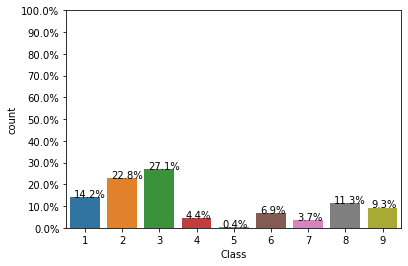

In [439]:
 %matplotlib inline

Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

## Feature extraction

### 1.Bytes Files

#### 1.1 Bytes filesize

In [440]:
for i in range(1, 11):
    for file in os.listdir(f'bytes/bytes{i}'):
        shutil.move(f'bytes/bytes{i}/'+file, 'byteFiles')

In [441]:
#file sizes of byte files

files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file+ '.txt')
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

                         ID      size  Class
0  7y28ZxJs9SKVYom13vbA.txt  2.261719      6
1  ipnL25WtfDEumwS9hNkU.txt  6.714844      3
2  70f4QazO1NlpXMST2LcE.txt  1.628906      6
3  BASrsZoQNCtedvFkT5Xz.txt  1.640625      6
4  AeQbnIpdNBfg8aDTRMlc.txt  0.363281      8


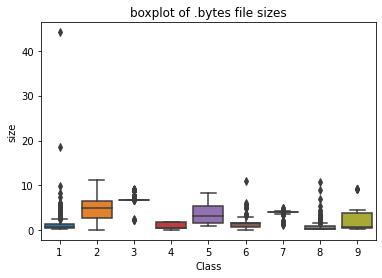

In [442]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

#### 1.2 bytes unigram features

In [ ]:
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000

files = os.listdir('byteFiles')
filenames=[]
array=[]
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        with open('byteFiles/'+file+".bytes","r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('byteFiles/'+file+".bytes")
        text_file.close()

files = os.listdir('byteFiles')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0


#program to convert into bag of words of bytefiles
#this is custom-built bag of words this is unigram bag of words
byte_feature_file=open('result.csv','w+')
byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")
byte_feature_file.write("\n")
for file in files:
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('byteFiles/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i, row in enumerate(feature_matrix[k]):
        if i!=len(feature_matrix[k])-1:
            byte_feature_file.write(str(row)+",")
        else:
            byte_feature_file.write(str(row))
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

#### 1.3 Bytes bigram features

In [443]:
# split the bytesfiles into 10 folder for multiprocessing

split = 10

def split_bytes(split):
    # making empty folders
    os.mkdir('bytes')
    for i in range(1, split+1):
        os.mkdir(f'bytes/bytes{i}')
        
    for idx, file in enumerate(os.listdir('byteFiles')):
        for i in range(split):
            if idx%split==i:
                shutil.move('byteFiles/'+file, f'bytes/bytes{i+1}')
    return "Done"

split_bytes(10)

'Done'

In [73]:
# extract the features of all the files 

# Since multiprocessing was not working with jupyter notebook. So I have enterd the code into a python file and run in by jupyter notebook


################################################code inside ectract_bigram.py#####################################################

# import tqdm
# import os
# import itertools
# import collections
# import multiprocessing
# from multiprocess import Process

# files = os.listdir('byteFiles')


# # unigram feature list
# hexcode_list = ['00', '11', '22', '33', '44', '55', '66', '77', '88', '99', '0A', '0B', '0C', '0D', '0E', '0F', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1A', '1B', '1C', '1D', '1E', '1F', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '2C', '2D', '2E', '2F', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3A', '3B', '3C', '3D', '3E', '3F', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '4A', '4B', '4C', '4D', '4E', '4F', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5A', '5B', '5C', '5D', '5E', '5F', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '6A', '6B', '6C', '6D', '6E', '6F', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '7A', '7B', '7C', '7D', '7E', '7F', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '8A', '8B', '8C', '8D', '8E', '8F', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '9A', '9B', '9C', '9D', '9E', '9F', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'DA', 'DB', 'DC', 'DD', 'dE', 'DF', 'E0', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'EA', 'EB', 'EC', 'ED', 'EE', 'Ef', 'F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'FA', 'FB', 'FC', 'FD', 'FE', 'FF', '??']

# # combination of unigram feature taken two at a time
# bigrams_features = list(itertools.combinations(hexcode_list, 2))


# # function to process folder1

# def fun1():
#     print('fun1 started...')

#     byte_feature_file=open('result_bigram1.csv','w+')
#     byte_feature_file.write('filename,')
 
#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
        
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes1'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes1/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                    
# # function to process folder2

# def fun2():
#     print('fun2 started...')
    
#     byte_feature_file=open('result_bigram2.csv','w+')
#     byte_feature_file.write('filename,')

#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes2'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes2/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):                                                                                                           byte_feature_file.write(','.join(bigram_feature_val))
# #                     byte_feature_file.write("\n")
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                
# # function to process folder3
                
# def fun3():
#     print('fun3 started...')
#     byte_feature_file=open('result_bigram3.csv','w+')
#     byte_feature_file.write('filename,')

#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
    
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes3'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes3/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):   
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                    
# # function to process folder4

# def fun4():
#     print('fun4 started...')

#     byte_feature_file=open('result_bigram4.csv','w+')
#     byte_feature_file.write('filename,')

    
#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
#     byte_feature_file.write("\n")
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes4'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes4/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features): 
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                    
# # function to process folder5

# def fun5():
#     print('fun5 started...')
#     byte_feature_file=open('result_bigram5.csv','w+')
#     byte_feature_file.write('filename,')
    
#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes5'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes5/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break


# # function to process folder6

# def fun6():
#     print('fun6 started...')


#     byte_feature_file=open('result_bigram6.csv','w+')
#     byte_feature_file.write('filename,')
 
#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
        
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes6'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes6/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                    
# # function to process folder7

# def fun7():
#     print('fun7 started...')

    
#     byte_feature_file=open('result_bigram7.csv','w+')
#     byte_feature_file.write('filename,')

#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes7'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes7/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):                                                                                                           byte_feature_file.write(','.join(bigram_feature_val))
# #                     byte_feature_file.write("\n")
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                
# # function to process folder8
                
# def fun8():
#     print('fun8 started...')

#     byte_feature_file=open('result_bigram8.csv','w+')
#     byte_feature_file.write('filename,')

#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
    
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes8'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes8/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):   
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                    
# # function to process folder9

# def fun9():
#     print('fun9 started...')

#     byte_feature_file=open('result_bigram9.csv','w+')
#     byte_feature_file.write('filename,')

    
#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
#     byte_feature_file.write("\n")
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes9'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes9/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features): 
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                    
# # function to process folder10

# def fun10():
#     print('fun10 started...')

#     byte_feature_file=open('result_bigram10.csv','w+')
#     byte_feature_file.write('filename,')
    
#     # write bigram features names
#     byte_feature_file.write(','.join(['_'.join(list(name)) for name in bigrams_features]))
    
#     # iterate for each file of .bytes file
#     for file in os.listdir('bytes/bytes10'):
#         byte_feature_file.write("\n")
#         byte_feature_file.write(file+",")
#         if(file.endswith("txt")):
#             # open file
#             with open('bytes/bytes10/'+file,"r") as byte_flie:
#                 # read the file
#                 content = byte_flie.readlines()
#                 # replace \n and space from content
#                 content = [line.replace('\n', '').rstrip().split(" ") for line in content]
#                 content = [' '.join(line) for line in content]
#                 # finding all the bigrams for content
#                 bigram_content = [b for l in content for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#                 # counting each bigram in content
#                 counter_dict = collections.Counter(bigram_content)
#                 bigram_feature_val = []
#                 for idx in range(len(bigrams_features)):
#                     try:
#                         bigram_feature_val.append(str(counter_dict[bigrams_features[idx]]))
#                     except:
#                         bigram_feature_val.append(str(0))
#                 if len(bigram_feature_val)==len(bigrams_features):
#                     byte_feature_file.write(','.join(bigram_feature_val))
#                 else:
#                     print("Got the list of length",len(bigram_feature_val), "and expected", len(bigrams_features))
#                     break
                    
                    
                    
# def main():
#     #the below code is used for multiprogramming
#     #the number of process depends upon the number of cores present System
#     #process is used to call multiprogramming
#     manager=multiprocessing.Manager() 
#     p1=Process(target=fun1)
#     p2=Process(target=fun2)
#     p3=Process(target=fun3)
#     p4=Process(target=fun4)
#     p5=Process(target=fun5)
#     p6=Process(target=fun6)
#     p7=Process(target=fun7)
#     p8=Process(target=fun8)
#     p9=Process(target=fun9)
#     p10=Process(target=fun10)

#     #p1.start() is used to start the thread execution
#     p1.start()
#     p2.start()
#     p3.start()
#     p4.start()
#     p5.start()
#     p6.start()
#     p7.start()
#     p8.start()
#     p9.start()
#     p10.start()

#     #After completion all the threads are joined
#     p1.join()
#     p2.join()
#     p3.join()
#     p4.join()
#     p5.join()
#     p6.join()
#     p7.join()
#     p8.join()
#     p9.join()
#     p10.join()


# if __name__=="__main__":
#     main()

########################################################Completed###############################################                   

! python extract_bigram.py

fun1 started..
fun2 started..
fun3 started..
fun4 started..
fun5 started..
fun6 started..
fun7 started..
fun8 started..
fun9 started..
fun10 started..
Done


### 2. ASM  files

#### 2.1 asm files size

In [444]:
#file sizes of byte files

files=os.listdir('asmFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file+ '.txt')
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

                         ID       size  Class
0  c4jU5YD9AmPipweFb7lO.txt  20.559470      2
1  cxHojJW4LKR1XOMPf2Zb.txt   0.191948      3
2  17zD8kITZONlBWYdfvr6.txt   0.120752      3
3  3nxujXtip8hGHb6ZQdA4.txt   5.205242      6
4  bCxz7M1oONFSUDvuKV9d.txt   0.122619      3


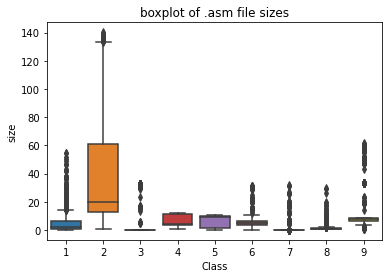

In [445]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .asm file sizes")
plt.show()

#### 2.2 extracting asm-image features

bytes image plot


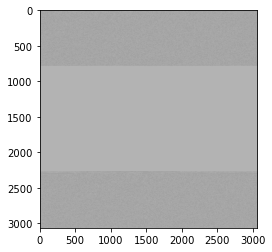

asm image plot


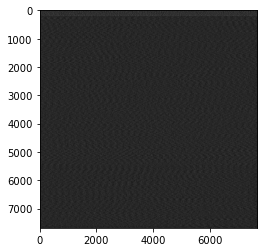

In [446]:
import array as array

# plotting bytes file
print('bytes image plot')
f = open('bytes/bytes10/0cdnSIvN489sFUwYlrMQ.txt', 'rb')
ln = os.path.getsize('bytes/bytes10/0cdnSIvN489sFUwYlrMQ.txt')
width = int(ln**0.5)
rem = ln%width
a = array.array("B")
a.fromfile(f, ln-rem)
f.close()
g = np.reshape(a, (int(len(a)/width), width))
g = np.uint8(g)
plt.imshow(g, 'gray')
plt.show()

print('asm image plot')
# plotting asm file
f = open('asmFiles/01azqd4InC7m9JpocGv5.asm', 'rb')
ln = os.path.getsize('asmFiles/01azqd4InC7m9JpocGv5.asm')
width = int(ln**0.5)
rem = ln%width
a = array.array("B")
a.fromfile(f, ln-rem)
f.close()
g = np.reshape(a, (int(len(a)/width), width))
g = np.uint8(g)
plt.imshow(g, 'gray')
plt.show()

In [ ]:
## extracting 800 feature from asm files

asm_files = os.listdir('asmFiles')

asm_img_features = np.zeros((len(asm_files), 800))
filename = []

for idx, file in tqdm.tqdm(enumerate(asm_files)):
    filename.append(file.split('.')[0])
    f = open('asmFiles/'+file, 'rb')
    ln = os.path.getsize('asmFiles/'+file)
    width = int(ln**0.5)
    rem = ln%width
    a = array.array("B")
    a.fromfile(f, ln-rem)
    f.close()
    g = np.reshape(a, (1, int(len(a)/width)*width))
    g = np.uint8(g)
    asm_img_features[idx, :] = g[0, 0:800]

In [ ]:
# saving features into csv
img_features = pd.DataFrame(asm_img_features)
img_features['filename'] = filename
img_features.to_csv('asm_img_features.csv', index = False)

### Loading features files

#### 1. Bigram feature selection by svd

In [394]:
# loading bigram files

biagram1 = pd.read_csv('result_bigram1.csv')
biagram2 = pd.read_csv('result_bigram2.csv')
biagram3 = pd.read_csv('result_bigram3.csv')
biagram4 = pd.read_csv('result_bigram4.csv')
biagram5 = pd.read_csv('result_bigram5.csv')
biagram6 = pd.read_csv('result_bigram6.csv')
biagram7 = pd.read_csv('result_bigram7.csv')
biagram8 = pd.read_csv('result_bigram8.csv')
biagram9 = pd.read_csv('result_bigram9.csv')
biagram10 = pd.read_csv('result_bigram10.csv')

bytes_bigram = pd.concat([biagram1, biagram2, biagram3, biagram4, biagram5, biagram6, biagram7, biagram8, biagram9, biagram10], axis = 0)

del biagram1
del biagram2
del biagram3
del biagram4
del biagram5
del biagram6
del biagram7
del biagram8
del biagram9
del biagram10

import gc
gc.collect()

In [223]:
from sklearn.decomposition import TruncatedSVD
# feature selection using SVD

svd_input = bytes_bigram.drop('filename', axis = 1)
# intialize svd
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

# fit, transform and save 
svd.fit(svd_input)
bytes_bigram_red = svd.transform(svd_input)
df_bigram_red = pd.DataFrame(bytes_bigram_red, columns = [f'bigram{i}' for i in range(1000)])
df_bigram_red['ID'] =  bytes_bigram['filename'].values
df_bigram_red.to_csv('bigram_svd.csv', index = False)

In [224]:
print('Total variance explained by taking 1000 dimention:', svd.explained_variance_ratio_.sum()*100, '%')

Total variance explained by taking 1000 dimention: 98.0576103233371 %


In [225]:
del svd_input
del bytes_bigram
del bytes_bigram_red

gc.collect()

44

In [447]:
# bytes files
bigram_svd = pd.read_csv('bigram_svd.csv')
unigram_bytes = pd.read_csv('result.csv')
asm_img = pd.read_csv('asm_img_features.csv')
asm_img = asm_img.rename(columns = lambda x:'img'+str(x))
asm_img['imgfilename'] = asm_img['imgfilename'] + '.txt'
asm_bow = pd.read_csv('asmoutputfile.csv')
asm_bow['ID'] = asm_bow['ID'] + '.txt'
asm_bow = asm_bow.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

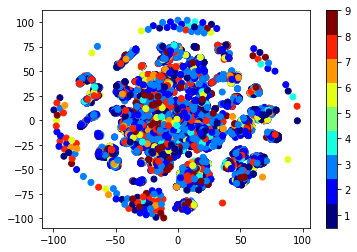

In [448]:
#multivariate analysis on byte files
#this is with perplexity 50
from sklearn.manifold import TSNE
label = data_size_byte['Class']
tsne_in = pd.merge(left=bigram_svd, right=data_size_byte, left_on='ID', right_on='ID').drop(['ID', 'size', 'Class'], axis = 1)
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(tsne_in)
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=label, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

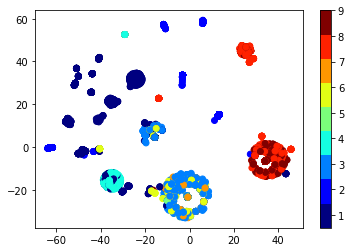

In [449]:
# tsne for img-asm features
label = asm_size_byte['Class']
tsne_in = pd.merge(left=asm_img, right=asm_size_byte, left_on='imgfilename', right_on='ID').drop(['ID', 'Class', 'imgfilename', 'size'], axis = 1)
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(tsne_in)
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=label, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

We have till now:
* Bytes
    * unigram_bytes ===> 257 features + filename
    * byets_bigram  ===> 32896 features + filename   =====after svd ===> 1000 feature + ID
    * data_size_byte===> 1 size + filename

* ASM
    * asm_img       ===> 800 features + filename
    * asm_bow       ===> 51 features + filename
    * asm_size_byte ===> 1 size + filename

## Concatenate all features

In [450]:
# for bytes file
bytes_features = pd.merge(left=bigram_svd, right=unigram_bytes, left_on='ID', right_on='ID')
bytes_features = pd.merge(left=bytes_features, right=data_size_byte, left_on='ID', right_on='ID')
print('Shape of bytes features', bytes_features.shape)

# for asm file
asm_features = pd.merge(left=asm_img, right=asm_bow , left_on='imgfilename', right_on='ID')
asm_features = asm_features.drop('imgfilename', axis = 1)
asm_features = pd.merge(left=asm_features, right=asm_size_byte , left_on='ID', right_on='ID')
print('Shape of asm features', asm_features.shape)

Shape of bytes features (10868, 1260)
Shape of asm features (10868, 854)


In [451]:
df = pd.merge(left=bytes_features, right=asm_features , left_on='ID', right_on='ID')
df = df.drop('Class_y', axis = 1)
print('Shape of df :',  df.shape)

Shape of df : (10868, 2112)


In [452]:
Y = df['Class_x']
X = df.drop(['Class_x', 'ID'], axis = 1)

In [464]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.25, stratify = Y)
print('Training data shape :', x_train.shape)
print('Validation data shape :', x_val.shape)

Training data shape : (8151, 2110)
Validation data shape : (2717, 2110)


# Feature selection

In [465]:
from sklearn.ensemble import RandomForestClassifier
# LightGBM model
import tqdm
from lightgbm import LGBMClassifier
from sklearn.calibration import calibration_curve
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score

def select_features(clf, x_train, x_val, num_feature, plot_graph, plot_top_10):
    feature_imp_idx = np.argsort(clf.feature_importances_)[::-1]
    if plot_graph:
        feature_imp_descending = clf.feature_importances_[feature_imp_idx]
        feature_name_descending = [x_train.columns[i] for i in feature_imp_idx]
        feature_imp_descending_cum = np.cumsum(feature_imp_descending)
        plt.barh(feature_name_descending, feature_imp_descending_cum)
        plt.title('Feature importance plot')
        plt.ylabel('feature_name')
        plt.xlabel('feature_imp_val')
        plt.show()
    if plot_top_10:
        # plotting 10 most important features
        top_10 = feature_imp_idx[:10]
        top_10_features_val = clf.feature_importances_[top_10]
        top_10_features = [x_train.columns[i] for i in top_10]
        plt.bar(top_10_features, top_10_features_val)
        plt.title('Top 10 most important features')
        plt.xlabel('feature_name')
        plt.ylabel('feature_imp_val')
        plt.show()

    x_train_f = x_train.iloc[:, feature_imp_idx[:num_feature]]
    x_val_f = x_val.iloc[:, feature_imp_idx[:num_feature]]
    return x_train_f, x_val_f

100%|██████████| 9/9 [00:36<00:00,  4.03s/it]


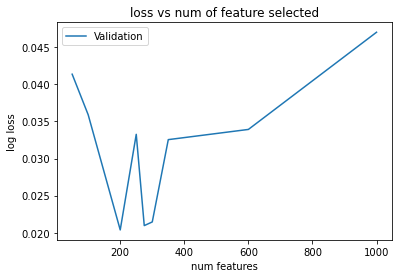

In [472]:
clf_r = RandomForestClassifier(n_estimators = 100)
clf_r.fit(x_train, y_train)

num_feature_list = [50, 100, 200, 250, 275, 300, 350, 600, 1000]
train_loss_list = []
val_loss_list = []
for num in tqdm.tqdm(num_feature_list):
    x_train_f, x_val_f = select_features(clf_r, x_train, x_val, num, False, False)
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(x_train_f, y_train)
    loss_train =  log_loss(y_train, clf.predict_proba(x_train_f))
    loss_val = log_loss(y_val, clf.predict_proba(x_val_f))
    train_loss_list.append(loss_train)
    val_loss_list.append(loss_val)

plt.plot(num_feature_list, val_loss_list)
plt.title('loss vs num of feature selected')
plt.xlabel('num features')
plt.ylabel('log loss')
plt.legend(['Validation'])
plt.show()
    

Since the above graph show minimum logloss on validation set on selecting 200 features, Lets take num_feature = 200

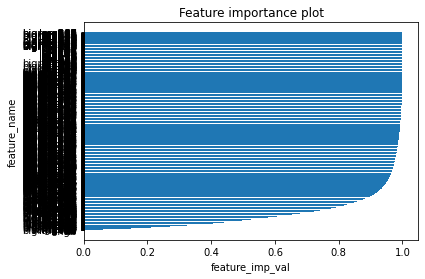

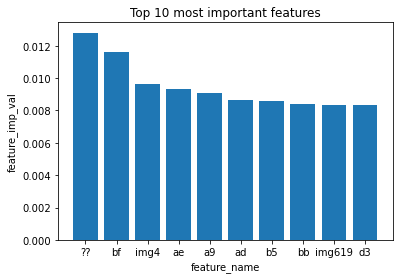

shape of training data (8151, 200)
shape of validation data (2717, 200)


In [473]:
x_train_f, x_val_f = select_features(clf_r, x_train, x_val, 200, True, True)
print('shape of training data', x_train_f.shape)
print('shape of validation data', x_val_f.shape)

# Modelling

In [474]:
! pip install optuna
import optuna

## 1. Logistic Regression

log_loss for c =  1e-05 is 1.211007400143872
log_loss for c =  0.0001 is 1.2170735073159578
log_loss for c =  0.001 is 1.1881978272467912
log_loss for c =  0.01 is 1.1962007387326843
log_loss for c =  0.1 is 1.171352477878957
log_loss for c =  1 is 1.201423564487005
log_loss for c =  10 is 1.2157676602922833
log_loss for c =  100 is 1.1924800824637163
log_loss for c =  1000 is 1.219310315927912


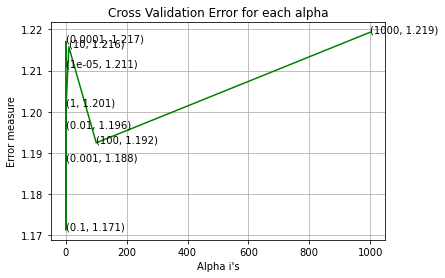

In [430]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(x_train_f,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(x_train_f, y_train)
    predict_y = sig_clf.predict_proba(x_val_f)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


## 2. Random Forest

log_loss for c =  10 is 0.02303558781822392
log_loss for c =  50 is 0.019646048646380414
log_loss for c =  100 is 0.019144437426392213
log_loss for c =  500 is 0.019155154782139337
log_loss for c =  1000 is 0.019288736495693515
log_loss for c =  2000 is 0.019275034893247063
log_loss for c =  3000 is 0.01927914248031234


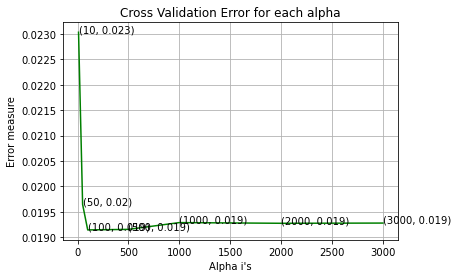

In [431]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_val)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


## 3. LightGBM

100%|██████████| 9/9 [01:16<00:00,  8.53s/it]


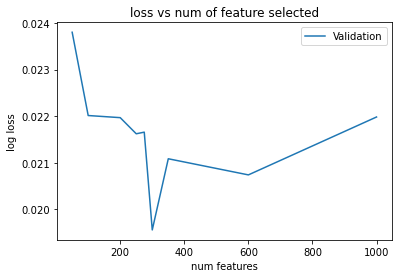

In [477]:
clf_lgb = LGBMClassifier(n_estimators = 100)
clf_lgb.fit(x_train, y_train)

num_feature_list = [50, 100, 200, 250, 275, 300, 350, 600, 1000]
train_loss_list = []
val_loss_list = []
for num in tqdm.tqdm(num_feature_list):
    x_train_f, x_val_f = select_features(clf_lgb, x_train, x_val, num, False, False)
    clf = LGBMClassifier(n_estimators = 100)
    clf.fit(x_train_f, y_train)
    loss_train =  log_loss(y_train, clf.predict_proba(x_train_f))
    loss_val = log_loss(y_val, clf.predict_proba(x_val_f))
    train_loss_list.append(loss_train)
    val_loss_list.append(loss_val)

plt.plot(num_feature_list, val_loss_list)
plt.title('loss vs num of feature selected')
plt.xlabel('num features')
plt.ylabel('log loss')
plt.legend(['Validation'])
plt.show()


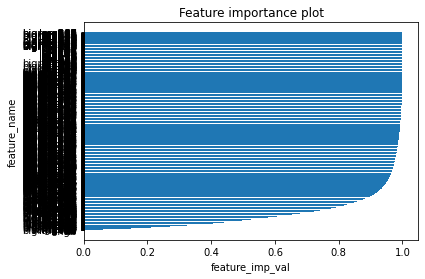

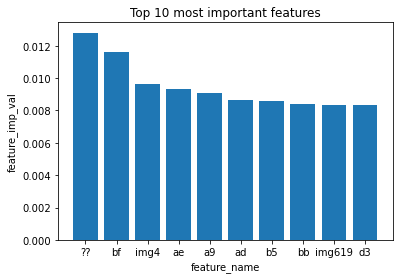

shape of training data (8151, 1000)
shape of validation data (2717, 1000)


In [479]:
x_train_lgb, x_val_lgb = select_features(clf_r, x_train, x_val, 300, True, True)
print('shape of training data', x_train_f.shape)
print('shape of validation data', x_val_f.shape)

In [483]:
from sklearn.model_selection import RandomizedSearchCV

clf_lgb = LGBMClassifier()

def objective(trial):
    est = [100, 150, 200, 250]
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', est),
        'num_leaves' : trial.suggest_int('num_leaves', 15, 40),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.8),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            }
    clf = LGBMClassifier(**param)
    clf.fit(x_train_lgb, y_train)
    return log_loss(y_val, clf.predict_proba(x_val_lgb.reset_index().drop('index', axis = 1)))

import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2021-07-08 12:43:10,846] A new study created in memory with name: no-name-beffae61-d6ce-416c-bdf9-da361cff6078
[I 2021-07-08 12:43:14,157] Trial 0 finished with value: 0.018625230123759093 and parameters: {'n_estimators': 250, 'num_leaves': 18, 'learning_rate': 0.06483654677881186, 'lambda_l1': 0.5842758637053559, 'lambda_l2': 0.0003856187762510298, 'feature_fraction': 0.7876404159381585, 'bagging_fraction': 0.7053339332309309, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 0 with value: 0.018625230123759093.


[LightGBM] [Warning] lambda_l1 is set=9.489443946399512e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.489443946399512e-07
[LightGBM] [Warning] bagging_fraction is set=0.5324180871142659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5324180871142659
[LightGBM] [Warning] lambda_l2 is set=0.0002523618545857657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002523618545857657
[LightGBM] [Warning] feature_fraction is set=0.860504376640514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860504376640514
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:43:16,940] Trial 1 finished with value: 0.013852143755019522 and parameters: {'n_estimators': 100, 'num_leaves': 17, 'learning_rate': 0.0708025474393647, 'lambda_l1': 9.489443946399512e-07, 'lambda_l2': 0.0002523618545857657, 'feature_fraction': 0.860504376640514, 'bagging_fraction': 0.5324180871142659, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=1.534241669620604e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.534241669620604e-05
[LightGBM] [Warning] bagging_fraction is set=0.8121092712373235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121092712373235
[LightGBM] [Warning] lambda_l2 is set=7.933836694913398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.933836694913398
[LightGBM] [Warning] feature_fraction is set=0.8424436162138722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424436162138722
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:43:22,494] Trial 2 finished with value: 0.014016422363348673 and parameters: {'n_estimators': 250, 'num_leaves': 27, 'learning_rate': 0.043510617365657145, 'lambda_l1': 1.534241669620604e-05, 'lambda_l2': 7.933836694913398, 'feature_fraction': 0.8424436162138722, 'bagging_fraction': 0.8121092712373235, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=2.912077567534174e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.912077567534174e-07
[LightGBM] [Warning] bagging_fraction is set=0.9327949083044225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9327949083044225
[LightGBM] [Warning] lambda_l2 is set=1.604958669267916e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.604958669267916e-05
[LightGBM] [Warning] feature_fraction is set=0.7358995620023565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7358995620023565
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:43:27,272] Trial 3 finished with value: 0.017399992747688643 and parameters: {'n_estimators': 200, 'num_leaves': 31, 'learning_rate': 0.08903906996077529, 'lambda_l1': 2.912077567534174e-07, 'lambda_l2': 1.604958669267916e-05, 'feature_fraction': 0.7358995620023565, 'bagging_fraction': 0.9327949083044225, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=1.211509923459117e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.211509923459117e-08
[LightGBM] [Warning] bagging_fraction is set=0.8022100617433587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8022100617433587
[LightGBM] [Warning] lambda_l2 is set=0.0002641345040915622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002641345040915622
[LightGBM] [Warning] feature_fraction is set=0.893341648950179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893341648950179
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:43:30,312] Trial 4 finished with value: 21.330904229171935 and parameters: {'n_estimators': 200, 'num_leaves': 22, 'learning_rate': 0.21523001791922625, 'lambda_l1': 1.211509923459117e-08, 'lambda_l2': 0.0002641345040915622, 'feature_fraction': 0.893341648950179, 'bagging_fraction': 0.8022100617433587, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=1.1207253068135339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1207253068135339
[LightGBM] [Warning] bagging_fraction is set=0.7465419715319952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465419715319952
[LightGBM] [Warning] lambda_l2 is set=9.436324332097954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.436324332097954
[LightGBM] [Warning] feature_fraction is set=0.43717324468000707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43717324468000707
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:43:33,786] Trial 5 finished with value: 0.017401077038807417 and parameters: {'n_estimators': 250, 'num_leaves': 28, 'learning_rate': 0.045827109181183, 'lambda_l1': 1.1207253068135339, 'lambda_l2': 9.436324332097954, 'feature_fraction': 0.43717324468000707, 'bagging_fraction': 0.7465419715319952, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=0.00044525677505945595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044525677505945595
[LightGBM] [Warning] bagging_fraction is set=0.6765189276827006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6765189276827006
[LightGBM] [Warning] lambda_l2 is set=0.03558289381862065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03558289381862065
[LightGBM] [Warning] feature_fraction is set=0.43868224719114157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43868224719114157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-07-08 12:43:37,223] Trial 6 finished with value: 0.01896848028614186 and parameters: {'n_estimators': 250, 'num_leaves': 20, 'learning_rate': 0.10798673187224554, 'lambda_l1': 0.00044525677505945595, 'lambda_l2': 0.03558289381862065, 'feature_fraction': 0.43868224719114157, 'bagging_fraction': 0.6765189276827006, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=0.033048168897954366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.033048168897954366
[LightGBM] [Warning] bagging_fraction is set=0.43889179296797465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43889179296797465
[LightGBM] [Warning] lambda_l2 is set=5.162974777132721e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.162974777132721e-05
[LightGBM] [Warning] feature_fraction is set=0.8044419435769874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044419435769874
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:43:38,300] Trial 7 finished with value: 15.39435413384103 and parameters: {'n_estimators': 100, 'num_leaves': 33, 'learning_rate': 0.4167985413790431, 'lambda_l1': 0.033048168897954366, 'lambda_l2': 5.162974777132721e-05, 'feature_fraction': 0.8044419435769874, 'bagging_fraction': 0.43889179296797465, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=0.1957369160499568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1957369160499568
[LightGBM] [Warning] bagging_fraction is set=0.8744091973756853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8744091973756853
[LightGBM] [Warning] lambda_l2 is set=1.8332406625026287e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8332406625026287e-05
[LightGBM] [Warning] feature_fraction is set=0.4941075492984853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4941075492984853
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:43:40,652] Trial 8 finished with value: 0.016126970446340278 and parameters: {'n_estimators': 200, 'num_leaves': 27, 'learning_rate': 0.08657931555907902, 'lambda_l1': 0.1957369160499568, 'lambda_l2': 1.8332406625026287e-05, 'feature_fraction': 0.4941075492984853, 'bagging_fraction': 0.8744091973756853, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=1.2290265023580475e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2290265023580475e-05
[LightGBM] [Warning] bagging_fraction is set=0.8168818625114285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8168818625114285
[LightGBM] [Warning] lambda_l2 is set=4.81800494287372e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.81800494287372e-06
[LightGBM] [Warning] feature_fraction is set=0.6288460551759731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6288460551759731
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:43:47,758] Trial 9 finished with value: 0.019677501332030247 and parameters: {'n_estimators': 200, 'num_leaves': 40, 'learning_rate': 0.02768382262921526, 'lambda_l1': 1.2290265023580475e-05, 'lambda_l2': 4.81800494287372e-06, 'feature_fraction': 0.6288460551759731, 'bagging_fraction': 0.8168818625114285, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=1.0853282080173077e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0853282080173077e-08
[LightGBM] [Warning] bagging_fraction is set=0.5015414075741673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015414075741673
[LightGBM] [Warning] lambda_l2 is set=1.0322950607548333e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0322950607548333e-07
[LightGBM] [Warning] feature_fraction is set=0.9993676064013274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993676064013274
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:43:53,517] Trial 10 finished with value: 0.05727090713731572 and parameters: {'n_estimators': 150, 'num_leaves': 15, 'learning_rate': 0.014798089315286318, 'lambda_l1': 1.0853282080173077e-08, 'lambda_l2': 1.0322950607548333e-07, 'feature_fraction': 0.9993676064013274, 'bagging_fraction': 0.5015414075741673, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=5.93385758897211e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.93385758897211e-06
[LightGBM] [Warning] bagging_fraction is set=0.6060475779503007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6060475779503007
[LightGBM] [Warning] lambda_l2 is set=0.056316419053982464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056316419053982464
[LightGBM] [Warning] feature_fraction is set=0.9556000619538225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9556000619538225
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:43:56,271] Trial 11 finished with value: 0.08224625814422222 and parameters: {'n_estimators': 100, 'num_leaves': 37, 'learning_rate': 0.019196186851650622, 'lambda_l1': 5.93385758897211e-06, 'lambda_l2': 0.056316419053982464, 'feature_fraction': 0.9556000619538225, 'bagging_fraction': 0.6060475779503007, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=0.0003283493215630729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003283493215630729
[LightGBM] [Warning] bagging_fraction is set=0.6108618877495513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6108618877495513
[LightGBM] [Warning] lambda_l2 is set=0.02513392908265159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02513392908265159
[LightGBM] [Warning] feature_fraction is set=0.8806449177339403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806449177339403
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:43:58,745] Trial 12 finished with value: 0.01938347239623085 and parameters: {'n_estimators': 100, 'num_leaves': 24, 'learning_rate': 0.03759521559044167, 'lambda_l1': 0.0003283493215630729, 'lambda_l2': 0.02513392908265159, 'feature_fraction': 0.8806449177339403, 'bagging_fraction': 0.6108618877495513, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 1 with value: 0.013852143755019522.


[LightGBM] [Warning] lambda_l1 is set=1.299579190543475e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.299579190543475e-06
[LightGBM] [Warning] bagging_fraction is set=0.9918860299254447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9918860299254447
[LightGBM] [Warning] lambda_l2 is set=7.152401371536316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.152401371536316
[LightGBM] [Warning] feature_fraction is set=0.6272442747455091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6272442747455091
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:44:00,998] Trial 13 finished with value: 0.011094750935057237 and parameters: {'n_estimators': 100, 'num_leaves': 16, 'learning_rate': 0.18877753881798146, 'lambda_l1': 1.299579190543475e-06, 'lambda_l2': 7.152401371536316, 'feature_fraction': 0.6272442747455091, 'bagging_fraction': 0.9918860299254447, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=2.2504671664063473e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2504671664063473e-07
[LightGBM] [Warning] bagging_fraction is set=0.5230073407507154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5230073407507154
[LightGBM] [Warning] lambda_l2 is set=2.5264318037868166e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5264318037868166e-07
[LightGBM] [Warning] feature_fraction is set=0.6432662729774712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6432662729774712
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:44:01,884] Trial 14 finished with value: 15.063838803080301 and parameters: {'n_estimators': 100, 'num_leaves': 15, 'learning_rate': 0.7958271622355041, 'lambda_l1': 2.2504671664063473e-07, 'lambda_l2': 2.5264318037868166e-07, 'feature_fraction': 0.6432662729774712, 'bagging_fraction': 0.5230073407507154, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=5.026799533351992e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.026799533351992e-07
[LightGBM] [Warning] bagging_fraction is set=0.4167173624535293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4167173624535293
[LightGBM] [Warning] lambda_l2 is set=0.0025833044143749816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025833044143749816
[LightGBM] [Warning] feature_fraction is set=0.5685891735283486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5685891735283486
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:44:03,095] Trial 15 finished with value: 12.242136980628631 and parameters: {'n_estimators': 100, 'num_leaves': 17, 'learning_rate': 0.21560155711516024, 'lambda_l1': 5.026799533351992e-07, 'lambda_l2': 0.0025833044143749816, 'feature_fraction': 0.5685891735283486, 'bagging_fraction': 0.4167173624535293, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.0065536308048182905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0065536308048182905
[LightGBM] [Warning] bagging_fraction is set=0.549173971804319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.549173971804319
[LightGBM] [Warning] lambda_l2 is set=0.39511901365275015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.39511901365275015
[LightGBM] [Warning] feature_fraction is set=0.6958383221009752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6958383221009752
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:44:05,447] Trial 16 finished with value: 0.011810696257267763 and parameters: {'n_estimators': 150, 'num_leaves': 15, 'learning_rate': 0.17641241784277195, 'lambda_l1': 0.0065536308048182905, 'lambda_l2': 0.39511901365275015, 'feature_fraction': 0.6958383221009752, 'bagging_fraction': 0.549173971804319, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.005347166081798191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005347166081798191
[LightGBM] [Warning] bagging_fraction is set=0.9906988049953059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906988049953059
[LightGBM] [Warning] lambda_l2 is set=0.8651080545243832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8651080545243832
[LightGBM] [Warning] feature_fraction is set=0.6894361331427646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6894361331427646
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:44:08,866] Trial 17 finished with value: 0.012950725028616475 and parameters: {'n_estimators': 150, 'num_leaves': 21, 'learning_rate': 0.1807427563151778, 'lambda_l1': 0.005347166081798191, 'lambda_l2': 0.8651080545243832, 'feature_fraction': 0.6894361331427646, 'bagging_fraction': 0.9906988049953059, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=9.450465708065853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.450465708065853
[LightGBM] [Warning] bagging_fraction is set=0.6064512009468166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6064512009468166
[LightGBM] [Warning] lambda_l2 is set=0.8554970697019961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8554970697019961
[LightGBM] [Warning] feature_fraction is set=0.5540983954468983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5540983954468983
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:44:10,057] Trial 18 finished with value: 0.05856928658654 and parameters: {'n_estimators': 150, 'num_leaves': 15, 'learning_rate': 0.41417336310989034, 'lambda_l1': 9.450465708065853, 'lambda_l2': 0.8554970697019961, 'feature_fraction': 0.5540983954468983, 'bagging_fraction': 0.6064512009468166, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.0035922879692084973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035922879692084973
[LightGBM] [Warning] bagging_fraction is set=0.46304064827684294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46304064827684294
[LightGBM] [Warning] lambda_l2 is set=0.7222403366161184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7222403366161184
[LightGBM] [Warning] feature_fraction is set=0.7349825791873827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7349825791873827
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-07-08 12:44:12,311] Trial 19 finished with value: 0.012312432270091671 and parameters: {'n_estimators': 150, 'num_leaves': 24, 'learning_rate': 0.34854714658887287, 'lambda_l1': 0.0035922879692084973, 'lambda_l2': 0.7222403366161184, 'feature_fraction': 0.7349825791873827, 'bagging_fraction': 0.46304064827684294, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=4.031051338842615e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.031051338842615e-05
[LightGBM] [Warning] bagging_fraction is set=0.9716393892164132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9716393892164132
[LightGBM] [Warning] lambda_l2 is set=7.959496542378681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.959496542378681
[LightGBM] [Warning] feature_fraction is set=0.5878608960956406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5878608960956406
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:44:15,380] Trial 20 finished with value: 0.017005713482215638 and parameters: {'n_estimators': 150, 'num_leaves': 19, 'learning_rate': 0.7852457317625059, 'lambda_l1': 4.031051338842615e-05, 'lambda_l2': 7.959496542378681, 'feature_fraction': 0.5878608960956406, 'bagging_fraction': 0.9716393892164132, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.00468735260813725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00468735260813725
[LightGBM] [Warning] bagging_fraction is set=0.403858358499818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.403858358499818
[LightGBM] [Warning] lambda_l2 is set=0.39714113102080356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.39714113102080356
[LightGBM] [Warning] feature_fraction is set=0.7235927662147407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7235927662147407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-07-08 12:44:17,279] Trial 21 finished with value: 0.013493686544063865 and parameters: {'n_estimators': 150, 'num_leaves': 24, 'learning_rate': 0.4127165434732075, 'lambda_l1': 0.00468735260813725, 'lambda_l2': 0.39714113102080356, 'feature_fraction': 0.7235927662147407, 'bagging_fraction': 0.403858358499818, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.0032269340223907827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032269340223907827
[LightGBM] [Warning] bagging_fraction is set=0.46190893890102025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46190893890102025
[LightGBM] [Warning] lambda_l2 is set=0.24809480522609173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24809480522609173
[LightGBM] [Warning] feature_fraction is set=0.6856528750407125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6856528750407125
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-07-08 12:44:19,320] Trial 22 finished with value: 0.013222735562711248 and parameters: {'n_estimators': 150, 'num_leaves': 24, 'learning_rate': 0.30205270356412833, 'lambda_l1': 0.0032269340223907827, 'lambda_l2': 0.24809480522609173, 'feature_fraction': 0.6856528750407125, 'bagging_fraction': 0.46190893890102025, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.04664201482202141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04664201482202141
[LightGBM] [Warning] bagging_fraction is set=0.5736785485213165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5736785485213165
[LightGBM] [Warning] lambda_l2 is set=2.7464160417019126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7464160417019126
[LightGBM] [Warning] feature_fraction is set=0.7571187353661541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571187353661541
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:44:21,955] Trial 23 finished with value: 0.01178368811761505 and parameters: {'n_estimators': 150, 'num_leaves': 15, 'learning_rate': 0.15251026569603163, 'lambda_l1': 0.04664201482202141, 'lambda_l2': 2.7464160417019126, 'feature_fraction': 0.7571187353661541, 'bagging_fraction': 0.5736785485213165, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.03710646922304738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03710646922304738
[LightGBM] [Warning] bagging_fraction is set=0.56297170449518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.56297170449518
[LightGBM] [Warning] lambda_l2 is set=5.50348712299922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.50348712299922
[LightGBM] [Warning] feature_fraction is set=0.781258634468319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.781258634468319
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:44:24,623] Trial 24 finished with value: 0.01171116336964546 and parameters: {'n_estimators': 150, 'num_leaves': 15, 'learning_rate': 0.13773345709324852, 'lambda_l1': 0.03710646922304738, 'lambda_l2': 5.50348712299922, 'feature_fraction': 0.781258634468319, 'bagging_fraction': 0.56297170449518, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.049142694001424285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.049142694001424285
[LightGBM] [Warning] bagging_fraction is set=0.6550822547649734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6550822547649734
[LightGBM] [Warning] lambda_l2 is set=9.932248911016686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.932248911016686
[LightGBM] [Warning] feature_fraction is set=0.7809469219493586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809469219493586
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:44:27,530] Trial 25 finished with value: 0.011893557475910192 and parameters: {'n_estimators': 150, 'num_leaves': 18, 'learning_rate': 0.1292304832279674, 'lambda_l1': 0.049142694001424285, 'lambda_l2': 9.932248911016686, 'feature_fraction': 0.7809469219493586, 'bagging_fraction': 0.6550822547649734, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=5.634585674624128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.634585674624128
[LightGBM] [Warning] bagging_fraction is set=0.5740135703278433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5740135703278433
[LightGBM] [Warning] lambda_l2 is set=2.332941148651878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.332941148651878
[LightGBM] [Warning] feature_fraction is set=0.6463913490900444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6463913490900444
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-07-08 12:44:28,927] Trial 26 finished with value: 0.03267012324170159 and parameters: {'n_estimators': 150, 'num_leaves': 16, 'learning_rate': 0.14400167793644789, 'lambda_l1': 5.634585674624128, 'lambda_l2': 2.332941148651878, 'feature_fraction': 0.6463913490900444, 'bagging_fraction': 0.5740135703278433, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=2.1194250202593476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1194250202593476
[LightGBM] [Warning] bagging_fraction is set=0.7290857425712447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7290857425712447
[LightGBM] [Warning] lambda_l2 is set=0.0046321142311767215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0046321142311767215
[LightGBM] [Warning] feature_fraction is set=0.7680870184828228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7680870184828228
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:44:30,106] Trial 27 finished with value: 0.02276605734926779 and parameters: {'n_estimators': 100, 'num_leaves': 20, 'learning_rate': 0.2843005787451508, 'lambda_l1': 2.1194250202593476, 'lambda_l2': 0.0046321142311767215, 'feature_fraction': 0.7680870184828228, 'bagging_fraction': 0.7290857425712447, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.06095118278802513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06095118278802513
[LightGBM] [Warning] bagging_fraction is set=0.6530208847231477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6530208847231477
[LightGBM] [Warning] lambda_l2 is set=2.7583169311928706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7583169311928706
[LightGBM] [Warning] feature_fraction is set=0.818993835779866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.818993835779866
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-07-08 12:44:33,313] Trial 28 finished with value: 0.012956057834519561 and parameters: {'n_estimators': 150, 'num_leaves': 17, 'learning_rate': 0.13671661739869415, 'lambda_l1': 0.06095118278802513, 'lambda_l2': 2.7583169311928706, 'feature_fraction': 0.818993835779866, 'bagging_fraction': 0.6530208847231477, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.18140946707486413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18140946707486413
[LightGBM] [Warning] bagging_fraction is set=0.503684338287112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.503684338287112
[LightGBM] [Warning] lambda_l2 is set=0.13390742104554196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13390742104554196
[LightGBM] [Warning] feature_fraction is set=0.911190645094534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.911190645094534
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:44:35,519] Trial 29 finished with value: 0.6128084984024287 and parameters: {'n_estimators': 150, 'num_leaves': 22, 'learning_rate': 0.5901001437501544, 'lambda_l1': 0.18140946707486413, 'lambda_l2': 0.13390742104554196, 'feature_fraction': 0.911190645094534, 'bagging_fraction': 0.503684338287112, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=7.382569348563242e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.382569348563242e-05
[LightGBM] [Warning] bagging_fraction is set=0.57397293798512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.57397293798512
[LightGBM] [Warning] lambda_l2 is set=0.0029865141868594364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029865141868594364
[LightGBM] [Warning] feature_fraction is set=0.504280106161802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.504280106161802
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:44:37,685] Trial 30 finished with value: 0.017404380031957132 and parameters: {'n_estimators': 100, 'num_leaves': 18, 'learning_rate': 0.0702933099528596, 'lambda_l1': 7.382569348563242e-05, 'lambda_l2': 0.0029865141868594364, 'feature_fraction': 0.504280106161802, 'bagging_fraction': 0.57397293798512, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 13 with value: 0.011094750935057237.


[LightGBM] [Warning] lambda_l1 is set=0.017358830825092122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017358830825092122
[LightGBM] [Warning] bagging_fraction is set=0.5499588039728969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5499588039728969
[LightGBM] [Warning] lambda_l2 is set=2.658069386015015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.658069386015015
[LightGBM] [Warning] feature_fraction is set=0.6647606104339516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6647606104339516
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:44:40,009] Trial 31 finished with value: 0.010586374808678904 and parameters: {'n_estimators': 150, 'num_leaves': 15, 'learning_rate': 0.16699396198672892, 'lambda_l1': 0.017358830825092122, 'lambda_l2': 2.658069386015015, 'feature_fraction': 0.6647606104339516, 'bagging_fraction': 0.5499588039728969, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.0011933069594902478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011933069594902478
[LightGBM] [Warning] bagging_fraction is set=0.6258570215515296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6258570215515296
[LightGBM] [Warning] lambda_l2 is set=1.4079707286015928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4079707286015928
[LightGBM] [Warning] feature_fraction is set=0.7649225049197378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649225049197378
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:44:42,742] Trial 32 finished with value: 0.012800760413384085 and parameters: {'n_estimators': 150, 'num_leaves': 15, 'learning_rate': 0.24924804058734112, 'lambda_l1': 0.0011933069594902478, 'lambda_l2': 1.4079707286015928, 'feature_fraction': 0.7649225049197378, 'bagging_fraction': 0.6258570215515296, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.016611452061679986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016611452061679986
[LightGBM] [Warning] bagging_fraction is set=0.5666100992706169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5666100992706169
[LightGBM] [Warning] lambda_l2 is set=2.900789228546512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.900789228546512
[LightGBM] [Warning] feature_fraction is set=0.6619250731049198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6619250731049198
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:44:45,129] Trial 33 finished with value: 0.011977723585751077 and parameters: {'n_estimators': 150, 'num_leaves': 17, 'learning_rate': 0.10174409229642802, 'lambda_l1': 0.016611452061679986, 'lambda_l2': 2.900789228546512, 'feature_fraction': 0.6619250731049198, 'bagging_fraction': 0.5666100992706169, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.26001214520718535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26001214520718535
[LightGBM] [Warning] bagging_fraction is set=0.48930752241304626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48930752241304626
[LightGBM] [Warning] lambda_l2 is set=1.0402860936526156e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0402860936526156e-08
[LightGBM] [Warning] feature_fraction is set=0.6048255578221071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6048255578221071
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-07-08 12:44:47,892] Trial 34 finished with value: 0.013439959897175911 and parameters: {'n_estimators': 250, 'num_leaves': 16, 'learning_rate': 0.05812955601973305, 'lambda_l1': 0.26001214520718535, 'lambda_l2': 1.0402860936526156e-08, 'feature_fraction': 0.6048255578221071, 'bagging_fraction': 0.48930752241304626, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.019960118784527397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019960118784527397
[LightGBM] [Warning] bagging_fraction is set=0.7063125489778781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7063125489778781
[LightGBM] [Warning] lambda_l2 is set=9.825674438554023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.825674438554023
[LightGBM] [Warning] feature_fraction is set=0.7263590890526774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7263590890526774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:44:50,812] Trial 35 finished with value: 0.012195093563588137 and parameters: {'n_estimators': 150, 'num_leaves': 19, 'learning_rate': 0.1649503314788248, 'lambda_l1': 0.019960118784527397, 'lambda_l2': 9.825674438554023, 'feature_fraction': 0.7263590890526774, 'bagging_fraction': 0.7063125489778781, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.40881364268435294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40881364268435294
[LightGBM] [Warning] bagging_fraction is set=0.552897104773597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.552897104773597
[LightGBM] [Warning] lambda_l2 is set=0.12898912275285418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12898912275285418
[LightGBM] [Warning] feature_fraction is set=0.8245630293744568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8245630293744568
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-07-08 12:44:52,924] Trial 36 finished with value: 0.013507404196656341 and parameters: {'n_estimators': 150, 'num_leaves': 16, 'learning_rate': 0.11380348415653754, 'lambda_l1': 0.40881364268435294, 'lambda_l2': 0.12898912275285418, 'feature_fraction': 0.8245630293744568, 'bagging_fraction': 0.552897104773597, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=3.96763164398429e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96763164398429e-08
[LightGBM] [Warning] bagging_fraction is set=0.7698946753039295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7698946753039295
[LightGBM] [Warning] lambda_l2 is set=0.014045430270773011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014045430270773011
[LightGBM] [Warning] feature_fraction is set=0.8462799877493478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8462799877493478
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:44:57,407] Trial 37 finished with value: 0.01625411533824051 and parameters: {'n_estimators': 250, 'num_leaves': 19, 'learning_rate': 0.19063546221861932, 'lambda_l1': 3.96763164398429e-08, 'lambda_l2': 0.014045430270773011, 'feature_fraction': 0.8462799877493478, 'bagging_fraction': 0.7698946753039295, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.0010142896147108703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010142896147108703
[LightGBM] [Warning] bagging_fraction is set=0.6807461443031627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807461443031627
[LightGBM] [Warning] lambda_l2 is set=4.242949868479563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.242949868479563
[LightGBM] [Warning] feature_fraction is set=0.5338212305715075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338212305715075
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:00,510] Trial 38 finished with value: 0.011184705334108412 and parameters: {'n_estimators': 200, 'num_leaves': 17, 'learning_rate': 0.23848499900077014, 'lambda_l1': 0.0010142896147108703, 'lambda_l2': 4.242949868479563, 'feature_fraction': 0.5338212305715075, 'bagging_fraction': 0.6807461443031627, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.0009184451909022432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009184451909022432
[LightGBM] [Warning] bagging_fraction is set=0.878313184115971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.878313184115971
[LightGBM] [Warning] lambda_l2 is set=5.281056374098029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.281056374098029
[LightGBM] [Warning] feature_fraction is set=0.5258089256111904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258089256111904
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:04,121] Trial 39 finished with value: 0.01139083482037332 and parameters: {'n_estimators': 200, 'num_leaves': 22, 'learning_rate': 0.543787922388375, 'lambda_l1': 0.0009184451909022432, 'lambda_l2': 5.281056374098029, 'feature_fraction': 0.5258089256111904, 'bagging_fraction': 0.878313184115971, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=9.789718576790147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.789718576790147e-05
[LightGBM] [Warning] bagging_fraction is set=0.9108389604495541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108389604495541
[LightGBM] [Warning] lambda_l2 is set=0.10984131982204708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10984131982204708
[LightGBM] [Warning] feature_fraction is set=0.5096540822177633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5096540822177633
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:06,810] Trial 40 finished with value: 0.8445297603626815 and parameters: {'n_estimators': 200, 'num_leaves': 26, 'learning_rate': 0.5834723864009927, 'lambda_l1': 9.789718576790147e-05, 'lambda_l2': 0.10984131982204708, 'feature_fraction': 0.5096540822177633, 'bagging_fraction': 0.9108389604495541, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 31 with value: 0.010586374808678904.


[LightGBM] [Warning] lambda_l1 is set=0.0010797175948809629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010797175948809629
[LightGBM] [Warning] bagging_fraction is set=0.853696610510952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853696610510952
[LightGBM] [Warning] lambda_l2 is set=5.069282289429096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.069282289429096
[LightGBM] [Warning] feature_fraction is set=0.5408402835529017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5408402835529017
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:10,402] Trial 41 finished with value: 0.010202938923870626 and parameters: {'n_estimators': 200, 'num_leaves': 30, 'learning_rate': 0.24943761579088314, 'lambda_l1': 0.0010797175948809629, 'lambda_l2': 5.069282289429096, 'feature_fraction': 0.5408402835529017, 'bagging_fraction': 0.853696610510952, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 41 with value: 0.010202938923870626.


[LightGBM] [Warning] lambda_l1 is set=0.0010717489706928045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010717489706928045
[LightGBM] [Warning] bagging_fraction is set=0.8284452696972061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284452696972061
[LightGBM] [Warning] lambda_l2 is set=9.465002067023095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.465002067023095
[LightGBM] [Warning] feature_fraction is set=0.4709663626754216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4709663626754216
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:13,711] Trial 42 finished with value: 0.010015277886790503 and parameters: {'n_estimators': 200, 'num_leaves': 31, 'learning_rate': 0.2566634700408301, 'lambda_l1': 0.0010717489706928045, 'lambda_l2': 9.465002067023095, 'feature_fraction': 0.4709663626754216, 'bagging_fraction': 0.8284452696972061, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0011321336632776448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011321336632776448
[LightGBM] [Warning] bagging_fraction is set=0.8383979383502668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383979383502668
[LightGBM] [Warning] lambda_l2 is set=1.2214573155316626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2214573155316626
[LightGBM] [Warning] feature_fraction is set=0.47037902364842193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47037902364842193
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:17,039] Trial 43 finished with value: 0.011706641353562686 and parameters: {'n_estimators': 200, 'num_leaves': 31, 'learning_rate': 0.23613677349867435, 'lambda_l1': 0.0011321336632776448, 'lambda_l2': 1.2214573155316626, 'feature_fraction': 0.47037902364842193, 'bagging_fraction': 0.8383979383502668, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=4.1619350965038365e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1619350965038365e-06
[LightGBM] [Warning] bagging_fraction is set=0.9468059150390183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9468059150390183
[LightGBM] [Warning] lambda_l2 is set=9.78539579520295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.78539579520295
[LightGBM] [Warning] feature_fraction is set=0.4181225024679638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4181225024679638
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:45:20,353] Trial 44 finished with value: 0.011811095229437745 and parameters: {'n_estimators': 200, 'num_leaves': 34, 'learning_rate': 0.3202836826165655, 'lambda_l1': 4.1619350965038365e-06, 'lambda_l2': 9.78539579520295, 'feature_fraction': 0.4181225024679638, 'bagging_fraction': 0.9468059150390183, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0005461450928195228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005461450928195228
[LightGBM] [Warning] bagging_fraction is set=0.7888209271979725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7888209271979725
[LightGBM] [Warning] lambda_l2 is set=4.0378004434851205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0378004434851205
[LightGBM] [Warning] feature_fraction is set=0.46548424476760597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46548424476760597
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:23,539] Trial 45 finished with value: 0.01037423858900243 and parameters: {'n_estimators': 200, 'num_leaves': 30, 'learning_rate': 0.2741134603678831, 'lambda_l1': 0.0005461450928195228, 'lambda_l2': 4.0378004434851205, 'feature_fraction': 0.46548424476760597, 'bagging_fraction': 0.7888209271979725, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0005921680373154641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005921680373154641
[LightGBM] [Warning] bagging_fraction is set=0.782626777719867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782626777719867
[LightGBM] [Warning] lambda_l2 is set=0.30826936092629603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30826936092629603
[LightGBM] [Warning] feature_fraction is set=0.46448276854310255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46448276854310255
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:45:26,492] Trial 46 finished with value: 0.02044567386146776 and parameters: {'n_estimators': 200, 'num_leaves': 30, 'learning_rate': 0.37030071838186973, 'lambda_l1': 0.0005921680373154641, 'lambda_l2': 0.30826936092629603, 'feature_fraction': 0.46448276854310255, 'bagging_fraction': 0.782626777719867, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.00016733671434545776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016733671434545776
[LightGBM] [Warning] bagging_fraction is set=0.8412902398761515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412902398761515
[LightGBM] [Warning] lambda_l2 is set=9.812582806459689e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.812582806459689e-05
[LightGBM] [Warning] feature_fraction is set=0.6188440069298804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6188440069298804
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:45:30,185] Trial 47 finished with value: 0.015527536376819145 and parameters: {'n_estimators': 200, 'num_leaves': 29, 'learning_rate': 0.08768490007800958, 'lambda_l1': 0.00016733671434545776, 'lambda_l2': 9.812582806459689e-05, 'feature_fraction': 0.6188440069298804, 'bagging_fraction': 0.8412902398761515, 'bagging_freq': 7, 'min_child_samples': 73}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=2.402002789194294e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.402002789194294e-05
[LightGBM] [Warning] bagging_fraction is set=0.8876057345141705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8876057345141705
[LightGBM] [Warning] lambda_l2 is set=1.8993426043396897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8993426043396897
[LightGBM] [Warning] feature_fraction is set=0.41323822417585576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41323822417585576
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:33,274] Trial 48 finished with value: 0.015893212501584188 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.4852528058926951, 'lambda_l1': 2.402002789194294e-05, 'lambda_l2': 1.8993426043396897, 'feature_fraction': 0.41323822417585576, 'bagging_fraction': 0.8876057345141705, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=2.1018069121551604e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1018069121551604e-06
[LightGBM] [Warning] bagging_fraction is set=0.8399637715753058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8399637715753058
[LightGBM] [Warning] lambda_l2 is set=0.6823265116996131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6823265116996131
[LightGBM] [Warning] feature_fraction is set=0.47054246012143086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47054246012143086
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:45:36,638] Trial 49 finished with value: 0.011202630029978903 and parameters: {'n_estimators': 200, 'num_leaves': 35, 'learning_rate': 0.20252081175239287, 'lambda_l1': 2.1018069121551604e-06, 'lambda_l2': 0.6823265116996131, 'feature_fraction': 0.47054246012143086, 'bagging_fraction': 0.8399637715753058, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.00014863288356394745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014863288356394745
[LightGBM] [Warning] bagging_fraction is set=0.7525553492493481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7525553492493481
[LightGBM] [Warning] lambda_l2 is set=3.3378806979229534e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3378806979229534e-06
[LightGBM] [Warning] feature_fraction is set=0.5652074512253505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652074512253505
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:45:38,692] Trial 50 finished with value: 13.67821987520203 and parameters: {'n_estimators': 200, 'num_leaves': 28, 'learning_rate': 0.2681873868697596, 'lambda_l1': 0.00014863288356394745, 'lambda_l2': 3.3378806979229534e-06, 'feature_fraction': 0.5652074512253505, 'bagging_fraction': 0.7525553492493481, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0018750622740815012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018750622740815012
[LightGBM] [Warning] bagging_fraction is set=0.7876443768801613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876443768801613
[LightGBM] [Warning] lambda_l2 is set=4.619215741698179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.619215741698179
[LightGBM] [Warning] feature_fraction is set=0.5300516746138038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5300516746138038
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:42,052] Trial 51 finished with value: 0.011080572961372877 and parameters: {'n_estimators': 200, 'num_leaves': 29, 'learning_rate': 0.2357761500601474, 'lambda_l1': 0.0018750622740815012, 'lambda_l2': 4.619215741698179, 'feature_fraction': 0.5300516746138038, 'bagging_fraction': 0.7876443768801613, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0021589989101250414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0021589989101250414
[LightGBM] [Warning] bagging_fraction is set=0.8031332052962092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031332052962092
[LightGBM] [Warning] lambda_l2 is set=9.532204990177773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.532204990177773
[LightGBM] [Warning] feature_fraction is set=0.44689756461910074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44689756461910074
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:45,200] Trial 52 finished with value: 0.010923274540376837 and parameters: {'n_estimators': 200, 'num_leaves': 31, 'learning_rate': 0.19294960080527723, 'lambda_l1': 0.0021589989101250414, 'lambda_l2': 9.532204990177773, 'feature_fraction': 0.44689756461910074, 'bagging_fraction': 0.8031332052962092, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.012234048798074201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012234048798074201
[LightGBM] [Warning] bagging_fraction is set=0.7968945827001034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968945827001034
[LightGBM] [Warning] lambda_l2 is set=4.496195075756792, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.496195075756792
[LightGBM] [Warning] feature_fraction is set=0.4422790027086795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4422790027086795
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:48,221] Trial 53 finished with value: 0.0112756982608895 and parameters: {'n_estimators': 200, 'num_leaves': 31, 'learning_rate': 0.2931685035984008, 'lambda_l1': 0.012234048798074201, 'lambda_l2': 4.496195075756792, 'feature_fraction': 0.4422790027086795, 'bagging_fraction': 0.7968945827001034, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0017249662270787606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017249662270787606
[LightGBM] [Warning] bagging_fraction is set=0.8177389804720697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8177389804720697
[LightGBM] [Warning] lambda_l2 is set=1.5692888727231684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5692888727231684
[LightGBM] [Warning] feature_fraction is set=0.4358668337205209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4358668337205209
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:45:51,392] Trial 54 finished with value: 0.012017620221725343 and parameters: {'n_estimators': 200, 'num_leaves': 32, 'learning_rate': 0.2134444895865738, 'lambda_l1': 0.0017249662270787606, 'lambda_l2': 1.5692888727231684, 'feature_fraction': 0.4358668337205209, 'bagging_fraction': 0.8177389804720697, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0003582945362242854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003582945362242854
[LightGBM] [Warning] bagging_fraction is set=0.8600956958763737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600956958763737
[LightGBM] [Warning] lambda_l2 is set=0.04507500786338714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04507500786338714
[LightGBM] [Warning] feature_fraction is set=0.4850678715261817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4850678715261817
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:45:54,178] Trial 55 finished with value: 0.0560254921499288 and parameters: {'n_estimators': 200, 'num_leaves': 29, 'learning_rate': 0.34408523900157933, 'lambda_l1': 0.0003582945362242854, 'lambda_l2': 0.04507500786338714, 'feature_fraction': 0.4850678715261817, 'bagging_fraction': 0.8600956958763737, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.009698256972840156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009698256972840156
[LightGBM] [Warning] bagging_fraction is set=0.7453652928969172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7453652928969172
[LightGBM] [Warning] lambda_l2 is set=9.043650219836696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.043650219836696
[LightGBM] [Warning] feature_fraction is set=0.5361975265186607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5361975265186607
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:45:57,461] Trial 56 finished with value: 0.010435143584607377 and parameters: {'n_estimators': 200, 'num_leaves': 27, 'learning_rate': 0.16505944043038526, 'lambda_l1': 0.009698256972840156, 'lambda_l2': 9.043650219836696, 'feature_fraction': 0.5361975265186607, 'bagging_fraction': 0.7453652928969172, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.00022873159441318716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022873159441318716
[LightGBM] [Warning] bagging_fraction is set=0.74074912416275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74074912416275
[LightGBM] [Warning] lambda_l2 is set=9.119290520045668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.119290520045668
[LightGBM] [Warning] feature_fraction is set=0.40224857321685636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40224857321685636
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:46:00,746] Trial 57 finished with value: 0.011863585482282403 and parameters: {'n_estimators': 200, 'num_leaves': 26, 'learning_rate': 0.16960715144715793, 'lambda_l1': 0.00022873159441318716, 'lambda_l2': 9.119290520045668, 'feature_fraction': 0.40224857321685636, 'bagging_fraction': 0.74074912416275, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.013310037080118112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013310037080118112
[LightGBM] [Warning] bagging_fraction is set=0.7132861352059253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7132861352059253
[LightGBM] [Warning] lambda_l2 is set=0.5816343798271962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5816343798271962
[LightGBM] [Warning] feature_fraction is set=0.5839809472554998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5839809472554998
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:46:04,128] Trial 58 finished with value: 0.011079888565285053 and parameters: {'n_estimators': 200, 'num_leaves': 38, 'learning_rate': 0.10078104324595925, 'lambda_l1': 0.013310037080118112, 'lambda_l2': 0.5816343798271962, 'feature_fraction': 0.5839809472554998, 'bagging_fraction': 0.7132861352059253, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.0030620966011768126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030620966011768126
[LightGBM] [Warning] bagging_fraction is set=0.761668386476525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761668386476525
[LightGBM] [Warning] lambda_l2 is set=0.0008580230783596044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008580230783596044
[LightGBM] [Warning] feature_fraction is set=0.5487806952376687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5487806952376687
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:46:06,888] Trial 59 finished with value: 0.013574517185601024 and parameters: {'n_estimators': 200, 'num_leaves': 35, 'learning_rate': 0.11990846790190114, 'lambda_l1': 0.0030620966011768126, 'lambda_l2': 0.0008580230783596044, 'feature_fraction': 0.5487806952376687, 'bagging_fraction': 0.761668386476525, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.09640886790827087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09640886790827087
[LightGBM] [Warning] bagging_fraction is set=0.8154793228013136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8154793228013136
[LightGBM] [Warning] lambda_l2 is set=9.578514438809956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.578514438809956
[LightGBM] [Warning] feature_fraction is set=0.44418337854233375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44418337854233375
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:09,980] Trial 60 finished with value: 0.010626107980888446 and parameters: {'n_estimators': 200, 'num_leaves': 32, 'learning_rate': 0.15974236830417501, 'lambda_l1': 0.09640886790827087, 'lambda_l2': 9.578514438809956, 'feature_fraction': 0.44418337854233375, 'bagging_fraction': 0.8154793228013136, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.008009066445428668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008009066445428668
[LightGBM] [Warning] bagging_fraction is set=0.8159699159420614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8159699159420614
[LightGBM] [Warning] lambda_l2 is set=9.352865715996543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.352865715996543
[LightGBM] [Warning] feature_fraction is set=0.4411778830964176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4411778830964176
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:13,099] Trial 61 finished with value: 0.010735383679560272 and parameters: {'n_estimators': 200, 'num_leaves': 32, 'learning_rate': 0.16140963641599476, 'lambda_l1': 0.008009066445428668, 'lambda_l2': 9.352865715996543, 'feature_fraction': 0.4411778830964176, 'bagging_fraction': 0.8159699159420614, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.08639626756697022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08639626756697022
[LightGBM] [Warning] bagging_fraction is set=0.8267704855019425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8267704855019425
[LightGBM] [Warning] lambda_l2 is set=1.3770072720669608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3770072720669608
[LightGBM] [Warning] feature_fraction is set=0.48654724518903825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48654724518903825
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:15,909] Trial 62 finished with value: 0.010110157417457731 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.1524012573377797, 'lambda_l1': 0.08639626756697022, 'lambda_l2': 1.3770072720669608, 'feature_fraction': 0.48654724518903825, 'bagging_fraction': 0.8267704855019425, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.11287155841908933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11287155841908933
[LightGBM] [Warning] bagging_fraction is set=0.89904440202739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.89904440202739
[LightGBM] [Warning] lambda_l2 is set=1.6427592979303658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6427592979303658
[LightGBM] [Warning] feature_fraction is set=0.4879306918986431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4879306918986431
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:18,697] Trial 63 finished with value: 0.01038880883222419 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.15392011248863915, 'lambda_l1': 0.11287155841908933, 'lambda_l2': 1.6427592979303658, 'feature_fraction': 0.4879306918986431, 'bagging_fraction': 0.89904440202739, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=1.0382431148769036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0382431148769036
[LightGBM] [Warning] bagging_fraction is set=0.9157544457978924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9157544457978924
[LightGBM] [Warning] lambda_l2 is set=0.18798996283492062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18798996283492062
[LightGBM] [Warning] feature_fraction is set=0.4816848901750928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4816848901750928
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:20,784] Trial 64 finished with value: 0.014212615204553452 and parameters: {'n_estimators': 200, 'num_leaves': 36, 'learning_rate': 0.12084246077790538, 'lambda_l1': 1.0382431148769036, 'lambda_l2': 0.18798996283492062, 'feature_fraction': 0.4816848901750928, 'bagging_fraction': 0.9157544457978924, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.13976201017335688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976201017335688
[LightGBM] [Warning] bagging_fraction is set=0.8606001805821955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8606001805821955
[LightGBM] [Warning] lambda_l2 is set=1.0787008834563425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0787008834563425
[LightGBM] [Warning] feature_fraction is set=0.5103393733612508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5103393733612508
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:23,041] Trial 65 finished with value: 0.011688497963947627 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.26534091720188846, 'lambda_l1': 0.13976201017335688, 'lambda_l2': 1.0787008834563425, 'feature_fraction': 0.5103393733612508, 'bagging_fraction': 0.8606001805821955, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.07946132923919359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07946132923919359
[LightGBM] [Warning] bagging_fraction is set=0.8851900699769247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8851900699769247
[LightGBM] [Warning] lambda_l2 is set=0.442762655943929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.442762655943929
[LightGBM] [Warning] feature_fraction is set=0.49597546892974287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49597546892974287
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:46:26,111] Trial 66 finished with value: 0.011113911559491766 and parameters: {'n_estimators': 200, 'num_leaves': 30, 'learning_rate': 0.07716502425191102, 'lambda_l1': 0.07946132923919359, 'lambda_l2': 0.442762655943929, 'feature_fraction': 0.49597546892974287, 'bagging_fraction': 0.8851900699769247, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 42 with value: 0.010015277886790503.


[LightGBM] [Warning] lambda_l1 is set=0.025757449938713192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025757449938713192
[LightGBM] [Warning] bagging_fraction is set=0.9174799930477201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9174799930477201
[LightGBM] [Warning] lambda_l2 is set=3.405536408412949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.405536408412949
[LightGBM] [Warning] feature_fraction is set=0.5894417352754746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5894417352754746
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:30,850] Trial 67 finished with value: 0.00967886438881175 and parameters: {'n_estimators': 250, 'num_leaves': 34, 'learning_rate': 0.2130818564423981, 'lambda_l1': 0.025757449938713192, 'lambda_l2': 3.405536408412949, 'feature_fraction': 0.5894417352754746, 'bagging_fraction': 0.9174799930477201, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.007826361581047474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007826361581047474
[LightGBM] [Warning] bagging_fraction is set=0.9692183935840113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9692183935840113
[LightGBM] [Warning] lambda_l2 is set=1.9071165638175462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9071165638175462
[LightGBM] [Warning] feature_fraction is set=0.54173793410895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54173793410895
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:35,489] Trial 68 finished with value: 0.014399183199179853 and parameters: {'n_estimators': 250, 'num_leaves': 34, 'learning_rate': 0.4007886227153876, 'lambda_l1': 0.007826361581047474, 'lambda_l2': 1.9071165638175462, 'feature_fraction': 0.54173793410895, 'bagging_fraction': 0.9692183935840113, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.025706392464678613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025706392464678613
[LightGBM] [Warning] bagging_fraction is set=0.9125032818941217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9125032818941217
[LightGBM] [Warning] lambda_l2 is set=3.8062449094265887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8062449094265887
[LightGBM] [Warning] feature_fraction is set=0.5805277096565432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805277096565432
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:46:39,409] Trial 69 finished with value: 0.010072675787205535 and parameters: {'n_estimators': 200, 'num_leaves': 27, 'learning_rate': 0.1449016721145549, 'lambda_l1': 0.025706392464678613, 'lambda_l2': 3.8062449094265887, 'feature_fraction': 0.5805277096565432, 'bagging_fraction': 0.9125032818941217, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.388656806414241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.388656806414241
[LightGBM] [Warning] bagging_fraction is set=0.9364442882353621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9364442882353621
[LightGBM] [Warning] lambda_l2 is set=0.014341133555974127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014341133555974127
[LightGBM] [Warning] feature_fraction is set=0.5725470832118464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5725470832118464
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:46:42,117] Trial 70 finished with value: 0.014915428316692318 and parameters: {'n_estimators': 250, 'num_leaves': 30, 'learning_rate': 0.14539182146539628, 'lambda_l1': 0.388656806414241, 'lambda_l2': 0.014341133555974127, 'feature_fraction': 0.5725470832118464, 'bagging_fraction': 0.9364442882353621, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.03752106784303497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03752106784303497
[LightGBM] [Warning] bagging_fraction is set=0.9203253071008639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203253071008639
[LightGBM] [Warning] lambda_l2 is set=3.448934590426777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.448934590426777
[LightGBM] [Warning] feature_fraction is set=0.5207548194084513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5207548194084513
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:46:46,441] Trial 71 finished with value: 0.010708900854292665 and parameters: {'n_estimators': 250, 'num_leaves': 27, 'learning_rate': 0.22642429883524953, 'lambda_l1': 0.03752106784303497, 'lambda_l2': 3.448934590426777, 'feature_fraction': 0.5207548194084513, 'bagging_fraction': 0.9203253071008639, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.02270798134247789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02270798134247789
[LightGBM] [Warning] bagging_fraction is set=0.8983649392988717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8983649392988717
[LightGBM] [Warning] lambda_l2 is set=0.7950243138869142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7950243138869142
[LightGBM] [Warning] feature_fraction is set=0.593255988149953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593255988149953
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:46:49,863] Trial 72 finished with value: 0.010963100863644168 and parameters: {'n_estimators': 200, 'num_leaves': 26, 'learning_rate': 0.20015723968245336, 'lambda_l1': 0.02270798134247789, 'lambda_l2': 0.7950243138869142, 'feature_fraction': 0.593255988149953, 'bagging_fraction': 0.8983649392988717, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.0005357279166516362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005357279166516362
[LightGBM] [Warning] bagging_fraction is set=0.8562045499814325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8562045499814325
[LightGBM] [Warning] lambda_l2 is set=5.067512590933241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.067512590933241
[LightGBM] [Warning] feature_fraction is set=0.5569727460307569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5569727460307569
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:46:54,511] Trial 73 finished with value: 0.011806668315801112 and parameters: {'n_estimators': 250, 'num_leaves': 28, 'learning_rate': 0.3094979395698609, 'lambda_l1': 0.0005357279166516362, 'lambda_l2': 5.067512590933241, 'feature_fraction': 0.5569727460307569, 'bagging_fraction': 0.8562045499814325, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.005463117160802299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005463117160802299
[LightGBM] [Warning] bagging_fraction is set=0.8264149627971257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8264149627971257
[LightGBM] [Warning] lambda_l2 is set=1.3275381865612048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3275381865612048
[LightGBM] [Warning] feature_fraction is set=0.46371690552721134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46371690552721134
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:46:58,065] Trial 74 finished with value: 0.010348604392267901 and parameters: {'n_estimators': 200, 'num_leaves': 34, 'learning_rate': 0.09985899297232288, 'lambda_l1': 0.005463117160802299, 'lambda_l2': 1.3275381865612048, 'feature_fraction': 0.46371690552721134, 'bagging_fraction': 0.8264149627971257, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.005423414684030354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005423414684030354
[LightGBM] [Warning] bagging_fraction is set=0.9506810135806443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9506810135806443
[LightGBM] [Warning] lambda_l2 is set=0.27106600183071095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27106600183071095
[LightGBM] [Warning] feature_fraction is set=0.4917241683215227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4917241683215227
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:47:02,276] Trial 75 finished with value: 0.011124577290800712 and parameters: {'n_estimators': 200, 'num_leaves': 38, 'learning_rate': 0.0981758458669914, 'lambda_l1': 0.005423414684030354, 'lambda_l2': 0.27106600183071095, 'feature_fraction': 0.4917241683215227, 'bagging_fraction': 0.9506810135806443, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.9552577814299649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9552577814299649
[LightGBM] [Warning] bagging_fraction is set=0.8988738211675776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8988738211675776
[LightGBM] [Warning] lambda_l2 is set=0.08440610694462881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08440610694462881
[LightGBM] [Warning] feature_fraction is set=0.45800247746334555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45800247746334555
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:47:04,285] Trial 76 finished with value: 0.014132079303231153 and parameters: {'n_estimators': 200, 'num_leaves': 34, 'learning_rate': 0.13395944172931665, 'lambda_l1': 0.9552577814299649, 'lambda_l2': 0.08440610694462881, 'feature_fraction': 0.45800247746334555, 'bagging_fraction': 0.8988738211675776, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.02702241093402833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02702241093402833
[LightGBM] [Warning] bagging_fraction is set=0.8330577591504623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8330577591504623
[LightGBM] [Warning] lambda_l2 is set=1.3112755451543407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3112755451543407
[LightGBM] [Warning] feature_fraction is set=0.4278820299785665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4278820299785665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:47:08,701] Trial 77 finished with value: 0.011530317989644337 and parameters: {'n_estimators': 250, 'num_leaves': 36, 'learning_rate': 0.050589226849552686, 'lambda_l1': 0.02702241093402833, 'lambda_l2': 1.3112755451543407, 'feature_fraction': 0.4278820299785665, 'bagging_fraction': 0.8330577591504623, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.11448925881756192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11448925881756192
[LightGBM] [Warning] bagging_fraction is set=0.8567216532637817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8567216532637817
[LightGBM] [Warning] lambda_l2 is set=0.49265778419149897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49265778419149897
[LightGBM] [Warning] feature_fraction is set=0.5145072668945121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145072668945121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:11,441] Trial 78 finished with value: 0.010359686078223029 and parameters: {'n_estimators': 200, 'num_leaves': 32, 'learning_rate': 0.1064449332472267, 'lambda_l1': 0.11448925881756192, 'lambda_l2': 0.49265778419149897, 'feature_fraction': 0.5145072668945121, 'bagging_fraction': 0.8567216532637817, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.23353134166255038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23353134166255038
[LightGBM] [Warning] bagging_fraction is set=0.8669802408966589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8669802408966589
[LightGBM] [Warning] lambda_l2 is set=0.4463765441706431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4463765441706431
[LightGBM] [Warning] feature_fraction is set=0.5136012905512372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5136012905512372
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:13,941] Trial 79 finished with value: 0.01157851243125586 and parameters: {'n_estimators': 200, 'num_leaves': 32, 'learning_rate': 0.10838666011745175, 'lambda_l1': 0.23353134166255038, 'lambda_l2': 0.4463765441706431, 'feature_fraction': 0.5136012905512372, 'bagging_fraction': 0.8669802408966589, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.0033729142953516224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033729142953516224
[LightGBM] [Warning] bagging_fraction is set=0.8505671705953598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505671705953598
[LightGBM] [Warning] lambda_l2 is set=2.9264581737544613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9264581737544613
[LightGBM] [Warning] feature_fraction is set=0.4564419537812072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4564419537812072
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:17,345] Trial 80 finished with value: 0.010850884105337527 and parameters: {'n_estimators': 200, 'num_leaves': 30, 'learning_rate': 0.07768326185270698, 'lambda_l1': 0.0033729142953516224, 'lambda_l2': 2.9264581737544613, 'feature_fraction': 0.4564419537812072, 'bagging_fraction': 0.8505671705953598, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.11673749044901095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11673749044901095
[LightGBM] [Warning] bagging_fraction is set=0.8749994030333049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8749994030333049
[LightGBM] [Warning] lambda_l2 is set=1.7448086719832945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7448086719832945
[LightGBM] [Warning] feature_fraction is set=0.47630345594974705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47630345594974705
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:21,050] Trial 81 finished with value: 0.010273473425180661 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.09290096638491548, 'lambda_l1': 0.11673749044901095, 'lambda_l2': 1.7448086719832945, 'feature_fraction': 0.47630345594974705, 'bagging_fraction': 0.8749994030333049, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.057020226604106605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.057020226604106605
[LightGBM] [Warning] bagging_fraction is set=0.8741292950364092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8741292950364092
[LightGBM] [Warning] lambda_l2 is set=0.7809592480475124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7809592480475124
[LightGBM] [Warning] feature_fraction is set=0.4017383353401842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4017383353401842
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:24,893] Trial 82 finished with value: 0.010530360531195156 and parameters: {'n_estimators': 200, 'num_leaves': 35, 'learning_rate': 0.08894618489637128, 'lambda_l1': 0.057020226604106605, 'lambda_l2': 0.7809592480475124, 'feature_fraction': 0.4017383353401842, 'bagging_fraction': 0.8741292950364092, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.5411667952322358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5411667952322358
[LightGBM] [Warning] bagging_fraction is set=0.8284498744765072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284498744765072
[LightGBM] [Warning] lambda_l2 is set=0.1844730172188452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1844730172188452
[LightGBM] [Warning] feature_fraction is set=0.6103908972769376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6103908972769376
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:28,097] Trial 83 finished with value: 0.01287143046239131 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.08030757946981348, 'lambda_l1': 0.5411667952322358, 'lambda_l2': 0.1844730172188452, 'feature_fraction': 0.6103908972769376, 'bagging_fraction': 0.8284498744765072, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=3.12209581509846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.12209581509846
[LightGBM] [Warning] bagging_fraction is set=0.9304882220778261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304882220778261
[LightGBM] [Warning] lambda_l2 is set=2.5414115659207828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5414115659207828
[LightGBM] [Warning] feature_fraction is set=0.4748838380262133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4748838380262133
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:31,230] Trial 84 finished with value: 0.02191185558106107 and parameters: {'n_estimators': 200, 'num_leaves': 34, 'learning_rate': 0.06623108695910772, 'lambda_l1': 3.12209581509846, 'lambda_l2': 2.5414115659207828, 'feature_fraction': 0.4748838380262133, 'bagging_fraction': 0.9304882220778261, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.030865861280648766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030865861280648766
[LightGBM] [Warning] bagging_fraction is set=0.7916746159460638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916746159460638
[LightGBM] [Warning] lambda_l2 is set=5.602485690929785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.602485690929785
[LightGBM] [Warning] feature_fraction is set=0.5010977467096934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010977467096934
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:35,981] Trial 85 finished with value: 0.010828859699223816 and parameters: {'n_estimators': 200, 'num_leaves': 31, 'learning_rate': 0.12138835671455377, 'lambda_l1': 0.030865861280648766, 'lambda_l2': 5.602485690929785, 'feature_fraction': 0.5010977467096934, 'bagging_fraction': 0.7916746159460638, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.0006865613531080206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006865613531080206
[LightGBM] [Warning] bagging_fraction is set=0.7785031017378359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7785031017378359
[LightGBM] [Warning] lambda_l2 is set=1.0618588190227192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0618588190227192
[LightGBM] [Warning] feature_fraction is set=0.42229375486664195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42229375486664195
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:38,033] Trial 86 finished with value: 0.010840578223521797 and parameters: {'n_estimators': 100, 'num_leaves': 32, 'learning_rate': 0.09772472996155973, 'lambda_l1': 0.0006865613531080206, 'lambda_l2': 1.0618588190227192, 'feature_fraction': 0.42229375486664195, 'bagging_fraction': 0.7785031017378359, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.06898086313548067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06898086313548067
[LightGBM] [Warning] bagging_fraction is set=0.8474663700019013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8474663700019013
[LightGBM] [Warning] lambda_l2 is set=3.4484299662014695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4484299662014695
[LightGBM] [Warning] feature_fraction is set=0.5731803731475125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5731803731475125
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:42,545] Trial 87 finished with value: 0.014140804563090557 and parameters: {'n_estimators': 200, 'num_leaves': 36, 'learning_rate': 0.037587139159894395, 'lambda_l1': 0.06898086313548067, 'lambda_l2': 3.4484299662014695, 'feature_fraction': 0.5731803731475125, 'bagging_fraction': 0.8474663700019013, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.19174391898303503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19174391898303503
[LightGBM] [Warning] bagging_fraction is set=0.8244499795334074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244499795334074
[LightGBM] [Warning] lambda_l2 is set=0.5008783035657547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5008783035657547
[LightGBM] [Warning] feature_fraction is set=0.6357437738370033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6357437738370033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:47:45,277] Trial 88 finished with value: 0.012876585553116231 and parameters: {'n_estimators': 200, 'num_leaves': 29, 'learning_rate': 0.1780840746891476, 'lambda_l1': 0.19174391898303503, 'lambda_l2': 0.5008783035657547, 'feature_fraction': 0.6357437738370033, 'bagging_fraction': 0.8244499795334074, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=5.710661543331611e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.710661543331611e-05
[LightGBM] [Warning] bagging_fraction is set=0.8030387094906408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8030387094906408
[LightGBM] [Warning] lambda_l2 is set=1.9187054491446605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9187054491446605
[LightGBM] [Warning] feature_fraction is set=0.5214925543729799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5214925543729799
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-07-08 12:47:50,081] Trial 89 finished with value: 0.011349792982773228 and parameters: {'n_estimators': 250, 'num_leaves': 31, 'learning_rate': 0.26192968362806635, 'lambda_l1': 5.710661543331611e-05, 'lambda_l2': 1.9187054491446605, 'feature_fraction': 0.5214925543729799, 'bagging_fraction': 0.8030387094906408, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.002464743548861007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002464743548861007
[LightGBM] [Warning] bagging_fraction is set=0.8749233446733059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8749233446733059
[LightGBM] [Warning] lambda_l2 is set=6.336746529227061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.336746529227061
[LightGBM] [Warning] feature_fraction is set=0.45813860225383457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45813860225383457
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:47:53,603] Trial 90 finished with value: 0.011651968480229036 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.46656679063625933, 'lambda_l1': 0.002464743548861007, 'lambda_l2': 6.336746529227061, 'feature_fraction': 0.45813860225383457, 'bagging_fraction': 0.8749233446733059, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.11065766722763783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11065766722763783
[LightGBM] [Warning] bagging_fraction is set=0.8981961007964481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8981961007964481
[LightGBM] [Warning] lambda_l2 is set=1.7329872392551982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7329872392551982
[LightGBM] [Warning] feature_fraction is set=0.4868991601114503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4868991601114503
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:47:56,856] Trial 91 finished with value: 0.010423292253504262 and parameters: {'n_estimators': 200, 'num_leaves': 34, 'learning_rate': 0.1397867946786565, 'lambda_l1': 0.11065766722763783, 'lambda_l2': 1.7329872392551982, 'feature_fraction': 0.4868991601114503, 'bagging_fraction': 0.8981961007964481, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.004948337324185039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004948337324185039
[LightGBM] [Warning] bagging_fraction is set=0.8913798788161371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8913798788161371
[LightGBM] [Warning] lambda_l2 is set=1.237801268167815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.237801268167815
[LightGBM] [Warning] feature_fraction is set=0.4726408699208436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4726408699208436
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-07-08 12:48:00,562] Trial 92 finished with value: 0.011167728036465213 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.11132737929523365, 'lambda_l1': 0.004948337324185039, 'lambda_l2': 1.237801268167815, 'feature_fraction': 0.4726408699208436, 'bagging_fraction': 0.8913798788161371, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.32954060333842927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32954060333842927
[LightGBM] [Warning] bagging_fraction is set=0.9678638509007331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9678638509007331
[LightGBM] [Warning] lambda_l2 is set=3.6668308433268284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6668308433268284
[LightGBM] [Warning] feature_fraction is set=0.500699755549191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500699755549191
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:48:03,695] Trial 93 finished with value: 0.010725573966637397 and parameters: {'n_estimators': 200, 'num_leaves': 35, 'learning_rate': 0.21858811597109676, 'lambda_l1': 0.32954060333842927, 'lambda_l2': 3.6668308433268284, 'feature_fraction': 0.500699755549191, 'bagging_fraction': 0.9678638509007331, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.0424671902326864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0424671902326864
[LightGBM] [Warning] bagging_fraction is set=0.9220914916217932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9220914916217932
[LightGBM] [Warning] lambda_l2 is set=0.6975466912280803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6975466912280803
[LightGBM] [Warning] feature_fraction is set=0.5350861980274852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5350861980274852
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:48:07,874] Trial 94 finished with value: 0.011860750240002434 and parameters: {'n_estimators': 200, 'num_leaves': 25, 'learning_rate': 0.06043498816569505, 'lambda_l1': 0.0424671902326864, 'lambda_l2': 0.6975466912280803, 'feature_fraction': 0.5350861980274852, 'bagging_fraction': 0.9220914916217932, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.1133050803531425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1133050803531425
[LightGBM] [Warning] bagging_fraction is set=0.9543874920348677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9543874920348677
[LightGBM] [Warning] lambda_l2 is set=0.3438602076334363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3438602076334363
[LightGBM] [Warning] feature_fraction is set=0.545830310119006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.545830310119006
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:48:10,560] Trial 95 finished with value: 0.012925488398879807 and parameters: {'n_estimators': 200, 'num_leaves': 32, 'learning_rate': 0.14826636678241936, 'lambda_l1': 0.1133050803531425, 'lambda_l2': 0.3438602076334363, 'feature_fraction': 0.545830310119006, 'bagging_fraction': 0.9543874920348677, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.6633950007442254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6633950007442254
[LightGBM] [Warning] bagging_fraction is set=0.9916214840017017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916214840017017
[LightGBM] [Warning] lambda_l2 is set=0.0712099177980073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0712099177980073
[LightGBM] [Warning] feature_fraction is set=0.486213373280739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.486213373280739
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:48:12,798] Trial 96 finished with value: 0.017123743238563107 and parameters: {'n_estimators': 200, 'num_leaves': 28, 'learning_rate': 0.1854753598733025, 'lambda_l1': 0.6633950007442254, 'lambda_l2': 0.0712099177980073, 'feature_fraction': 0.486213373280739, 'bagging_fraction': 0.9916214840017017, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.014511322026505779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014511322026505779
[LightGBM] [Warning] bagging_fraction is set=0.8640701587464179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8640701587464179
[LightGBM] [Warning] lambda_l2 is set=2.1219873614054037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1219873614054037
[LightGBM] [Warning] feature_fraction is set=0.514707760048612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514707760048612
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:48:16,425] Trial 97 finished with value: 0.012421183485721543 and parameters: {'n_estimators': 200, 'num_leaves': 33, 'learning_rate': 0.34878116668338877, 'lambda_l1': 0.014511322026505779, 'lambda_l2': 2.1219873614054037, 'feature_fraction': 0.514707760048612, 'bagging_fraction': 0.8640701587464179, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=0.15299908313924512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15299908313924512
[LightGBM] [Warning] bagging_fraction is set=0.9078232454003623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078232454003623
[LightGBM] [Warning] lambda_l2 is set=6.699768018950106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.699768018950106
[LightGBM] [Warning] feature_fraction is set=0.5951443692496223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951443692496223
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-07-08 12:48:20,702] Trial 98 finished with value: 0.010412473334761422 and parameters: {'n_estimators': 200, 'num_leaves': 31, 'learning_rate': 0.09376354168324742, 'lambda_l1': 0.15299908313924512, 'lambda_l2': 6.699768018950106, 'feature_fraction': 0.5951443692496223, 'bagging_fraction': 0.9078232454003623, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 67 with value: 0.00967886438881175.


[LightGBM] [Warning] lambda_l1 is set=1.9693722833814369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9693722833814369
[LightGBM] [Warning] bagging_fraction is set=0.8457607631081625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457607631081625
[LightGBM] [Warning] lambda_l2 is set=0.2057826818272584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2057826818272584
[LightGBM] [Warning] feature_fraction is set=0.4533367514755159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4533367514755159
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-07-08 12:48:22,756] Trial 99 finished with value: 0.0166684231009352 and parameters: {'n_estimators': 200, 'num_leaves': 30, 'learning_rate': 0.12815657490985014, 'lambda_l1': 1.9693722833814369, 'lambda_l2': 0.2057826818272584, 'feature_fraction': 0.4533367514755159, 'bagging_fraction': 0.8457607631081625, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 67 with value: 0.00967886438881175.


In [484]:
best = study.best_params
best

{'n_estimators': 250,
 'num_leaves': 34,
 'learning_rate': 0.2130818564423981,
 'lambda_l1': 0.025757449938713192,
 'lambda_l2': 3.405536408412949,
 'feature_fraction': 0.5894417352754746,
 'bagging_fraction': 0.9174799930477201,
 'bagging_freq': 5,
 'min_child_samples': 75}

In [489]:
clf_lgb = LGBMClassifier(n_estimators= 250,
                     num_leaves= 34,
                     learning_rate= 0.2130818564423981,
                     lambda_l1= 0.025757449938713192,
                     lambda_l2= 3.405536408412949,
                     feature_fraction= 0.5894417352754746,
                     bagging_fraction= 0.9174799930477201,
                     bagging_freq= 5,
                     min_child_samples= 75
                    )
clf_lgb.fit(x_train_lgb, y_train)
print('*'*100)

print('Train error for LightGBM Classifier is ', log_loss(y_train, clf_lgb.predict_proba(x_train_lgb)))
print('Cross Validation error for LightGBM Classifier is ',log_loss(y_val, clf_lgb.predict_proba(x_val_lgb)))

[LightGBM] [Warning] lambda_l1 is set=0.025757449938713192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025757449938713192
[LightGBM] [Warning] bagging_fraction is set=0.9174799930477201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9174799930477201
[LightGBM] [Warning] lambda_l2 is set=3.405536408412949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.405536408412949
[LightGBM] [Warning] feature_fraction is set=0.5894417352754746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5894417352754746
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
****************************************************************************************************
Train error for LightGBM Classifier is  0.00017021813719157107
Cross Validation error for LightGBM Classifier is  0.00967886438881175


In [488]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

The train log loss is: 0.00017021813719157107
The cross validation log loss is: 0.00967886438881175
============================================================ Matrix for Training data ============================================================
Number of misclassified points  0.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


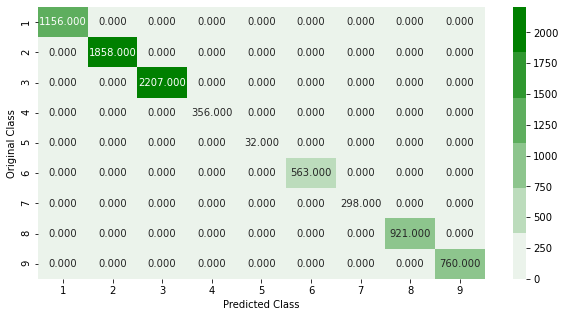

-------------------------------------------------- Precision matrix --------------------------------------------------


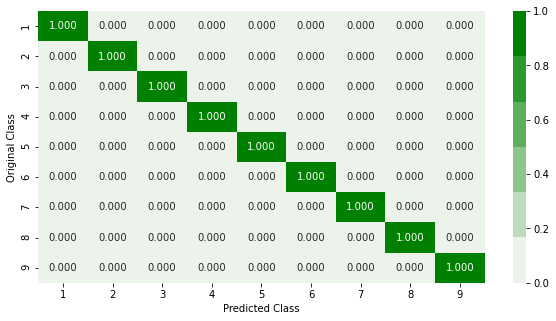

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


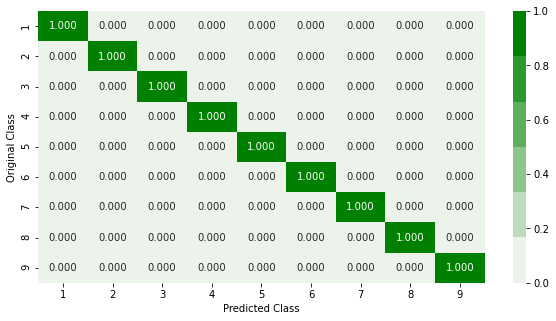

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
============================================================ Matrix for Validation data ============================================================
Number of misclassified points  0.25763709974236293
-------------------------------------------------- Confusion matrix --------------------------------------------------


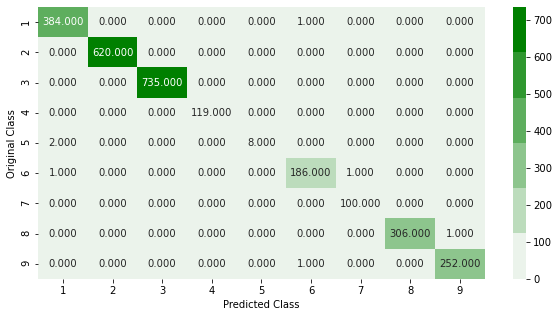

-------------------------------------------------- Precision matrix --------------------------------------------------


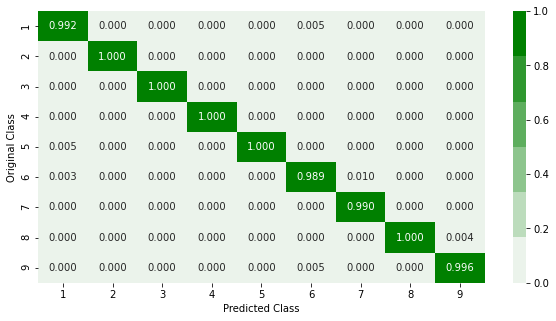

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


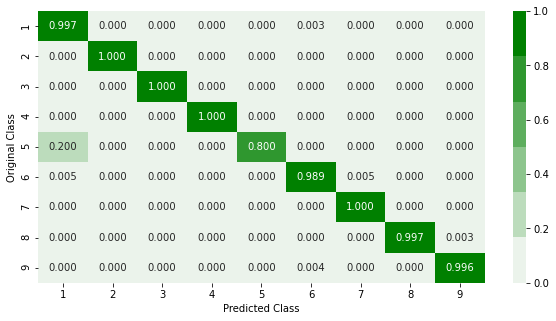

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [495]:
predict_y = clf_lgb.predict_proba(x_train_lgb)
print ("The train log loss is:",log_loss(y_train, predict_y))

predict_y = clf_lgb.predict_proba(x_val_lgb)
print("The cross validation log loss is:",log_loss(y_val, predict_y))

print('='*60, 'Matrix for Training data', '='*60)
plot_confusion_matrix(y_train, clf_lgb.predict(x_train_lgb))

print('='*60, 'Matrix for Validation data', '='*60)
plot_confusion_matrix(y_val, clf_lgb.predict(x_val_lgb))